# Analyse van de huidige stand in de golfcompetitie

Als alle uitslagen mogelijk zijn kunnen vier teams op gelijke stand komen. Broekpolder kampioen en de rest op 3 winstpunten en 33 partijpunten voor. Twee van de vier degraderen, ik weet niet welke twee.

```
============  =================  ==============  =============  ============  ==============  ===========  ==========  ============
  duke_eindh    broekp_haagsche    eindh_broekp    wouwse_duke    broekp_tot    haagsche_tot    eindh_tot    duke_tot    wouwse_tot
============  =================  ==============  =============  ============  ==============  ===========  ==========  ============
           9                 12               2             12          8048            3033         3033        3033          3033
============  =================  ==============  =============  ============  ==============  ===========  ==========  ============
```

Er zijn ook veel mogelijkheden met drie teams op gelijke stand, maar veel van die standen komen door uitslagen die niet heel realistisch zijn. Ik doe twee aannames waardoor het overzichtelijker wordt:

- wouwse wint niet van duke
- maximale uitslag is 14-4 (of 4-14)

Er zijn dan nog drie uitslagen waarbij drie ties zijn. Twee ervan leiden tot drie kampioenen. Eén leidt tot een gedeelde twee plek, waarbij één van de drie degradeert waarbij het zal gaan om het [totaal aantal gewonnen holes](https://www.golf.nl/-/media/pdfs/ngf/competitie/2024/ngf-competitiereglement2024-def.pdf?rev=209326393)."

```
============  =================  ==============  =============  ============  ==============  ===========  ==========  ============
  duke_eindh    broekp_haagsche    eindh_broekp    wouwse_duke    broekp_tot    haagsche_tot    eindh_tot    duke_tot    wouwse_tot
============  =================  ==============  =============  ============  ==============  ===========  ==========  ============
           8                  9               4              8          7043            4036         4036        4036          1029
           9                  4              10              4          4032            5041         5041        5041          1025
           9                  8               9              8          5037            5037         4040        5037          1029
============  =================  ==============  =============  ============  ==============  ===========  ==========  ============
```

Op basis van de wedstrijdpunten en partijpunten bepaal ik de ranking. Indien de Haagsche gelijk staat met een ander team en het is van invloed op het kampioenschap of degradatie dan bepaal ik de werkelijke rank. Voor andere teams laat ik de rank onveranderd.

Tot slot bepaal ik met een decision tree welke uitslagen tot welke uitkomst leiden.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score

In [2]:
pd.set_option('display.max_columns', None) 

In [3]:
cols = ['club', 'P', 'WP', 'W', 'L', 'D', 'pp+', 'pp-']
data = [
    ['broekp', 2, 4, 2, 0, 0, 20, 16],
    ['haagsche', 3, 3, 1, 1, 1, 27, 27],
    ['eindh', 2, 2, 1, 0, 0, 22, 14],
    ['duke', 2, 2, 1, 1, 0, 18, 18],
    ['wouwse', 3, 1, 0, 2, 1, 21, 33],
]
stand = pd.DataFrame(data = data, columns = cols)
stand.set_index('club', inplace=True)
stand

,P,WP,W,L,D,pp+,pp-
club,,,,,,,
broekp,2,4,2,0,0,20,16
haagsche,3,3,1,1,1,27,27
eindh,2,2,1,0,0,22,14
duke,2,2,1,1,0,18,18
wouwse,3,1,0,2,1,21,33


In [4]:
wedstrijden = [
    'duke_eindh',
    'broekp_haagsche',
    'eindh_broekp',
    'wouwse_duke',
]
uitslagen = list(range(19))
data = list(product(uitslagen, uitslagen, uitslagen, uitslagen))
resultaat = pd.DataFrame(data, columns=wedstrijden)

In [5]:
for club in stand.index.values:
    resultaat[f'{club}_wp_start'] = stand.loc[club, 'WP']
    resultaat[f'{club}_pp+_start'] = stand.loc[club, 'pp+']
    resultaat[f'{club}_pp-_start'] = stand.loc[club, 'pp-']

In [6]:
for club in stand.index.values:
    resultaat[f'{club}_wp_extra'] = 0
    resultaat[f'{club}_pp+_extra'] = 0
    resultaat[f'{club}_pp-_extra'] = 0
    
    for wedstrijd in wedstrijden:
        if wedstrijd.startswith(club):
            resultaat[f'{club}_wp_extra'] += (resultaat[wedstrijd] > 9) * 2 + (resultaat[wedstrijd] == 9)
            resultaat[f'{club}_pp+_extra'] += resultaat[wedstrijd]
            resultaat[f'{club}_pp-_extra'] += 18 - resultaat[wedstrijd]
        elif wedstrijd.endswith(club):
            resultaat[f'{club}_wp_extra'] += (resultaat[wedstrijd] < 9) * 2 + (resultaat[wedstrijd] == 9)
            resultaat[f'{club}_pp+_extra'] += 18 - resultaat[wedstrijd]
            resultaat[f'{club}_pp-_extra'] += resultaat[wedstrijd]

    resultaat[f'{club}_wp'] = resultaat[f'{club}_wp_start'] + resultaat[f'{club}_wp_extra']
    resultaat[f'{club}_pp+'] = resultaat[f'{club}_pp+_start'] + resultaat[f'{club}_pp+_extra']
    resultaat[f'{club}_pp-'] = resultaat[f'{club}_pp-_start'] + resultaat[f'{club}_pp-_extra']

wp_ppp_kolommen = list()
for club in stand.index.values:
    resultaat[f'{club}_tot'] = resultaat[f'{club}_wp'] * 1000 + resultaat[f'{club}_pp+']
    wp_ppp_kolommen.append(f'{club}_tot')

In [7]:
resultaat[wedstrijden+wp_ppp_kolommen].head()

,duke_eindh,broekp_haagsche,eindh_broekp,wouwse_duke,broekp_tot,haagsche_tot,eindh_tot,duke_tot,wouwse_tot
0,0,0,0,0,6038,5045,4040,4036,1021
1,0,0,0,1,6038,5045,4040,4035,1022
2,0,0,0,2,6038,5045,4040,4034,1023
3,0,0,0,3,6038,5045,4040,4033,1024
4,0,0,0,4,6038,5045,4040,4032,1025


In [8]:
nun = resultaat[wp_ppp_kolommen].nunique(axis=1)
nun.value_counts()

5    123272
4      6913
3       135
2         1
Name: count, dtype: int64

## Bijzondere situatie

Er zouden 4 teams op gelijke stand kunnen komen... (als we alle uitslagen mogelijk achten)

In [9]:
resultaat.loc[nun == 2, wedstrijden+wp_ppp_kolommen]
# print(resultaat.loc[nun == 2, wedstrijden+wp_ppp_kolommen].to_markdown(headers='keys', tablefmt='rst', index=False))

,duke_eindh,broekp_haagsche,eindh_broekp,wouwse_duke,broekp_tot,haagsche_tot,eindh_tot,duke_tot,wouwse_tot
66113,9,12,2,12,8048,3033,3033,3033,3033


## Aannames

- wouwse wint niet van duke
- max uitslag is 14-4 of 4-14

In [10]:
wouwse_wint_niet = resultaat['wouwse_duke'] < 10
milde_uitslag = resultaat[wedstrijden].apply(pd.Series.between, args=(4, 14)).all(axis=1)

resultaat = resultaat[wouwse_wint_niet & milde_uitslag]
# resultaat = resultaat[milde_uitslag]

In [11]:
resultaat.shape

(7986, 54)

In [12]:
nun = resultaat[wp_ppp_kolommen].nunique(axis=1)
nun.value_counts()

5    7418
4     563
3       5
Name: count, dtype: int64

In [13]:
resultaat.loc[nun == 3, wedstrijden+wp_ppp_kolommen]
# print(resultaat.loc[nun == 3, wedstrijden+wp_ppp_kolommen].to_markdown(headers='keys', tablefmt='rst', index=False))

,duke_eindh,broekp_haagsche,eindh_broekp,wouwse_duke,broekp_tot,haagsche_tot,eindh_tot,duke_tot,wouwse_tot
58205,8,9,4,8,7043,4036,4036,4036,1029
63369,9,4,10,4,4032,5041,5041,5041,1025
64798,9,8,9,8,5037,5037,4040,5037,1029
71658,10,8,9,9,5037,5037,3039,5037,2030
97555,14,4,4,9,6038,5041,2030,5041,2030


In [14]:
resultaat.loc[nun==4, wedstrijden+wp_ppp_kolommen]

,duke_eindh,broekp_haagsche,eindh_broekp,wouwse_duke,broekp_tot,haagsche_tot,eindh_tot,duke_tot,wouwse_tot
29078,4,4,10,8,4032,5041,6046,4032,1029
29438,4,5,10,7,4033,5040,6046,4033,1028
29458,4,5,11,8,4032,5040,6047,4032,1029
29798,4,6,10,6,4034,5039,6046,4034,1027
29818,4,6,11,7,4033,5039,6047,4033,1028
...,...,...,...,...,...,...,...,...,...
100082,14,11,4,9,8045,3034,2030,5041,2030
100443,14,12,4,9,8046,3033,2030,5041,2030
100804,14,13,4,9,8047,3032,2030,5041,2030
101165,14,14,4,9,8048,3031,2030,5041,2030


In [15]:
rank_cols = [c.replace('tot', 'rank') for c in wp_ppp_kolommen]
rank_cols

['broekp_rank', 'haagsche_rank', 'eindh_rank', 'duke_rank', 'wouwse_rank']

In [16]:
# let op: method=max is worst case (i.e. in geval gelijke stand gaan we uit van laagste stand.) niet per se waar, want gaat dan om onderling resultaat.
# min value zou best case zijn.
# average handig om ties te spotten

resultaat[rank_cols] = (
    resultaat[wp_ppp_kolommen].apply(
        lambda row: row.rank(method='max', ascending=False), axis=1)
)

In [17]:
resultaat['haagsche_rank'].value_counts()

haagsche_rank
4.0    3121
2.0    2641
3.0    2150
1.0      74
Name: count, dtype: int64

# Rank van Haagsche aanpassen

De ranks waarbij drie ties zijn laat ik achterwege. Lastig op te lossen. 

Indien er een enkele gelijke stand is, én de Haagsche is een van de clubs, dan pas ik de rank van de Haagsche aan. Alleen de rank van de Haagsche is van invloed op de target labels. De rank van de Haagsche wordt 1 beter indien gelijk met Eindhoven, en wordt 1 beter indien gelijk met Broekpolder én er wordt gewonnen van Broekpolder. Tegen de Duke is al verloren dus dan verandert niks aan de rank.

Let op: belangrijk is dat de rank is bepaald met method=max

In [18]:
# assuming we used method=max to determine rank !!
# moet overeenkomen met nunique==4 (eerder berekend)

enkele_gelijke_rank = (resultaat[rank_cols].sum(axis=1) == 16)
enkele_gelijke_rank.sum()

assert enkele_gelijke_rank.sum() == nun.value_counts()[4]

# meerdere_gelijke_ranks = (resultaat[rank_cols].sum(axis=1) > 16)

In [19]:
haagsche_rank_gelijk_eindh = resultaat.haagsche_rank == resultaat.eindh_rank  # gewonnen
haagsche_rank_gelijk_duke = resultaat.haagsche_rank == resultaat.duke_rank  # verloren
haagsche_rank_gelijk_broekp = resultaat.haagsche_rank == resultaat.broekp_rank
haagsche_win_broekp = resultaat.broekp_haagsche < 9

In [20]:
resultaat.loc[enkele_gelijke_rank & haagsche_rank_gelijk_eindh, 'haagsche_rank'] -= 1
resultaat.loc[enkele_gelijke_rank & haagsche_win_broekp & haagsche_rank_gelijk_broekp, 'haagsche_rank'] -= 1

In [21]:
resultaat['haagsche_rank'].value_counts()

haagsche_rank
4.0    3099
2.0    2693
3.0    2108
1.0      86
Name: count, dtype: int64

# Maak targets

In [22]:
resultaat['haagsche_kampioen'] = (resultaat['haagsche_rank'] == 1) * 1
resultaat['haagsche_degradeert'] = (resultaat['haagsche_rank'] >= 4) * 1

In [23]:
# extra features

resultaat['broekp_haagsche_gelijk'] = (resultaat.broekp_haagsche == 9) * 1
resultaat['wouwse_duke_gelijk'] = (resultaat.wouwse_duke == 9) * 1
resultaat['eindh_broekp_gelijk'] = (resultaat.eindh_broekp == 9) * 1
resultaat['duke_eindh_gelijk'] = (resultaat.duke_eindh == 9) * 1

In [24]:
resultaat.describe()

,duke_eindh,broekp_haagsche,eindh_broekp,wouwse_duke,broekp_wp_start,broekp_pp+_start,broekp_pp-_start,haagsche_wp_start,haagsche_pp+_start,haagsche_pp-_start,eindh_wp_start,eindh_pp+_start,eindh_pp-_start,duke_wp_start,duke_pp+_start,duke_pp-_start,wouwse_wp_start,wouwse_pp+_start,wouwse_pp-_start,broekp_wp_extra,broekp_pp+_extra,broekp_pp-_extra,broekp_wp,broekp_pp+,broekp_pp-,haagsche_wp_extra,haagsche_pp+_extra,haagsche_pp-_extra,haagsche_wp,haagsche_pp+,haagsche_pp-,eindh_wp_extra,eindh_pp+_extra,eindh_pp-_extra,eindh_wp,eindh_pp+,eindh_pp-,duke_wp_extra,duke_pp+_extra,duke_pp-_extra,duke_wp,duke_pp+,duke_pp-,wouwse_wp_extra,wouwse_pp+_extra,wouwse_pp-_extra,wouwse_wp,wouwse_pp+,wouwse_pp-,broekp_tot,haagsche_tot,eindh_tot,duke_tot,wouwse_tot,broekp_rank,haagsche_rank,eindh_rank,duke_rank,wouwse_rank,haagsche_kampioen,haagsche_degradeert,broekp_haagsche_gelijk,wouwse_duke_gelijk,eindh_broekp_gelijk,duke_eindh_gelijk
count,7986.000000,7986.000000,7986.000000,7986.000000,7986.0,7986.0,7986.0,7986.0,7986.0,7986.0,7986.0,7986.0,7986.0,7986.0,7986.0,7986.0,7986.0,7986.0,7986.0,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.0,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000,7986.000000
mean,9.000000,9.000000,9.000000,6.500000,4.0,20.0,16.0,3.0,27.0,27.0,2.0,22.0,14.0,2.0,18.0,18.0,1.0,21.0,33.0,2.000000,18.000000,18.000000,6.000000,38.000000,34.000000,1.000000,9.000000,9.000000,4.000000,36.000000,36.000000,2.000000,18.000000,18.000000,4.000000,40.000000,32.000000,2.833333,20.500000,15.500000,4.833333,38.500000,33.500000,0.166667,6.500000,11.500000,1.166667,27.500000,44.500000,6038.000000,4036.000000,4040.000000,4871.833333,1194.166667,1.971074,3.029301,2.643251,2.416354,5.0,0.010769,0.388054,0.090909,0.166667,0.090909,0.090909
std,3.162476,3.162476,3.162476,1.707932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.348484,4.472416,4.472416,1.348484,4.472416,4.472416,0.953522,3.162476,3.162476,0.953522,3.162476,3.162476,1.348484,4.472416,4.472416,1.348484,4.472416,4.472416,1.023773,3.594201,3.594201,1.023773,3.594201,3.594201,0.372701,1.707932,1.707932,0.372701,1.707932,1.707932,1352.530952,956.383808,1352.530952,1026.845960,373.821665,1.129350,0.876118,1.126813,1.061693,0.0,0.103219,0.487338,0.287498,0.372701,0.287498,0.287498
min,4.000000,4.000000,4.000000,4.000000,4.0,20.0,16.0,3.0,27.0,27.0,2.0,22.0,14.0,2.0,18.0,18.0,1.0,21.0,33.0,0.000000,8.000000,8.000000,4.000000,28.000000,24.000000,0.000000,4.000000,4.000000,3.000000,31.000000,31.000000,0.000000,8.000000,8.000000,2.000000,30.000000,22.000000,1.000000,13.000000,8.000000,3.000000,31.000000,26.000000,0.000000,4.000000,9.000000,1.000000,25.000000,42.000000,4028.000000,3031.000000,2030.000000,3031.000000,1025.000000,1.000000,1.000000,1.000000,1.000000,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,6.000000,6.000000,5.000000,4.0,20.0,16.0,3.0,27.0,27.0,2.0,22.0,14.0,2.0,18.0,18.0,1.0,21.0,33.0,1.000000,15.000000,15.000000,5.000000,35.000000,31.000000,0.000000,6.000000,6.000000,3.000000,33.000000,33.000000,1.000000,15.000000,15.000000,3.000000,37.000000,29.000000,2.000000,18.000000,13.000000,4.000000,36.000000,31.000000,0.000000,5.000000,10.000000,1.000000,26.000000,43.000000,5035.000000,3033.000000,3037.000000,4036.000000,1026.000000,1.000000,2.000000,2.000000,1.000000,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,9.000000,9.000000,6.500000,4.0,20.0,16.0,3.0,27.0,27.0,2.0,22.0,14.0,2.0,18.0,18.0,1.0,21.0,33.0,2.000000,18.000000,18.000000,6.000000,38.000000,34.000000,1.000000,9.000000,9.0

In [25]:
resultaat.sample(5)

,duke_eindh,broekp_haagsche,eindh_broekp,wouwse_duke,broekp_wp_start,broekp_pp+_start,broekp_pp-_start,haagsche_wp_start,haagsche_pp+_start,haagsche_pp-_start,eindh_wp_start,eindh_pp+_start,eindh_pp-_start,duke_wp_start,duke_pp+_start,duke_pp-_start,wouwse_wp_start,wouwse_pp+_start,wouwse_pp-_start,broekp_wp_extra,broekp_pp+_extra,broekp_pp-_extra,broekp_wp,broekp_pp+,broekp_pp-,haagsche_wp_extra,haagsche_pp+_extra,haagsche_pp-_extra,haagsche_wp,haagsche_pp+,haagsche_pp-,eindh_wp_extra,eindh_pp+_extra,eindh_pp-_extra,eindh_wp,eindh_pp+,eindh_pp-,duke_wp_extra,duke_pp+_extra,duke_pp-_extra,duke_wp,duke_pp+,duke_pp-,wouwse_wp_extra,wouwse_pp+_extra,wouwse_pp-_extra,wouwse_wp,wouwse_pp+,wouwse_pp-,broekp_tot,haagsche_tot,eindh_tot,duke_tot,wouwse_tot,broekp_rank,haagsche_rank,eindh_rank,duke_rank,wouwse_rank,haagsche_kampioen,haagsche_degradeert,broekp_haagsche_gelijk,wouwse_duke_gelijk,eindh_broekp_gelijk,duke_eindh_gelijk
93354,13,11,11,7,4,20,16,3,27,27,2,22,14,2,18,18,1,21,33,2,18,18,6,38,34,0,7,11,3,34,38,2,16,20,4,38,34,4,24,12,6,42,30,0,7,11,1,28,44,6038,3034,4038,6042,1028,2.0,4.0,3.0,1.0,5.0,0,1,0,0,0,0
50776,7,7,12,8,4,20,16,3,27,27,2,22,14,2,18,18,1,21,33,0,13,23,4,33,39,2,11,7,5,38,34,4,23,13,6,45,27,2,17,19,4,35,37,0,8,10,1,29,43,4033,5038,6045,4035,1029,4.0,2.0,1.0,3.0,5.0,0,0,0,0,0,0
84616,12,6,7,9,4,20,16,3,27,27,2,22,14,2,18,18,1,21,33,2,17,19,6,37,35,2,12,6,5,39,33,0,13,23,2,35,37,3,21,15,5,39,33,1,9,9,2,30,42,6037,5039,2035,5039,2030,1.0,3.0,4.0,3.0,5.0,0,0,0,1,0,0
73424,10,13,7,8,4,20,16,3,27,27,2,22,14,2,18,18,1,21,33,4,24,12,8,44,28,0,5,13,3,32,40,0,15,21,2,37,35,4,20,16,6,38,34,0,8,10,1,29,43,8044,3032,2037,6038,1029,1.0,3.0,4.0,2.0,5.0,0,0,0,0,0,0
66583,9,13,8,7,4,20,16,3,27,27,2,22,14,2,18,18,1,21,33,4,23,13,8,43,29,0,5,13,3,32,40,1,17,19,3,39,33,3,20,16,5,38,34,0,7,11,1,28,44,8043,3032,3039,5038,1028,1.0,4.0,3.0,2.0,5.0,0,1,0,0,0,1


In [26]:
resultaat.loc[resultaat['haagsche_kampioen'] == 1, wedstrijden + wp_ppp_kolommen].head()

,duke_eindh,broekp_haagsche,eindh_broekp,wouwse_duke,broekp_tot,haagsche_tot,eindh_tot,duke_tot,wouwse_tot
56491,8,4,9,4,5033,5041,5041,4040,1025
56492,8,4,9,5,5033,5041,5041,4039,1026
56493,8,4,9,6,5033,5041,5041,4038,1027
56494,8,4,9,7,5033,5041,5041,4037,1028
56495,8,4,9,8,5033,5041,5041,4036,1029


In [27]:
def make_model_etc(target, features, labels, fig_name):
    print(f'{target=}')

    X = resultaat[features]
    y = resultaat[target]

    model = DecisionTreeClassifier()
    model.fit(X, y)

    plt.figure(figsize=(10, 10))
    plot_tree(model, feature_names=features, class_names=labels, rounded=True, filled=True)
    plt.savefig(fig_name, dpi=800)
    plt.show()

    # check: should be 100% correct
    pred = model.predict(X)
    assert accuracy_score(resultaat[target], pred) == 1

# Kans dat Haagsche kampioen wordt

In [28]:
fig_name = 'kampioen.svg'

target = 'haagsche_kampioen'
labels = ['niet kampioen', 'kampioen']

features = wedstrijden

target='haagsche_kampioen'


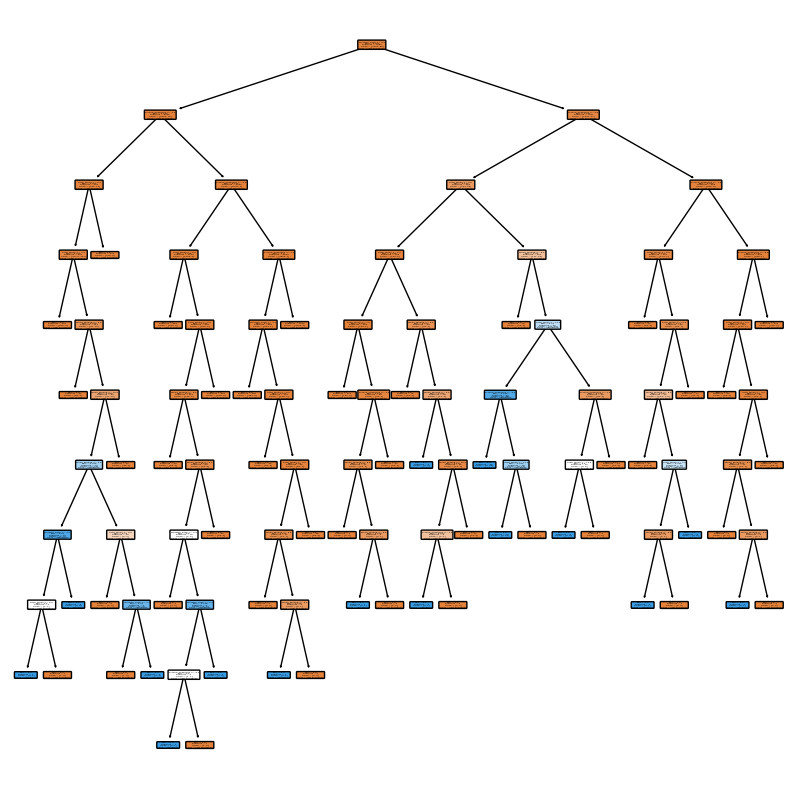

In [29]:
make_model_etc(target, features, labels, fig_name)

In [30]:
fig_name = 'kampioen_extra_features.svg'

target = 'haagsche_kampioen'
labels = ['niet kampioen', 'kampioen']

features = wedstrijden + [
    'eindh_broekp_gelijk',
    'broekp_haagsche_gelijk', 
    'duke_eindh_gelijk',
    'wouwse_duke_gelijk',
]

target='haagsche_kampioen'


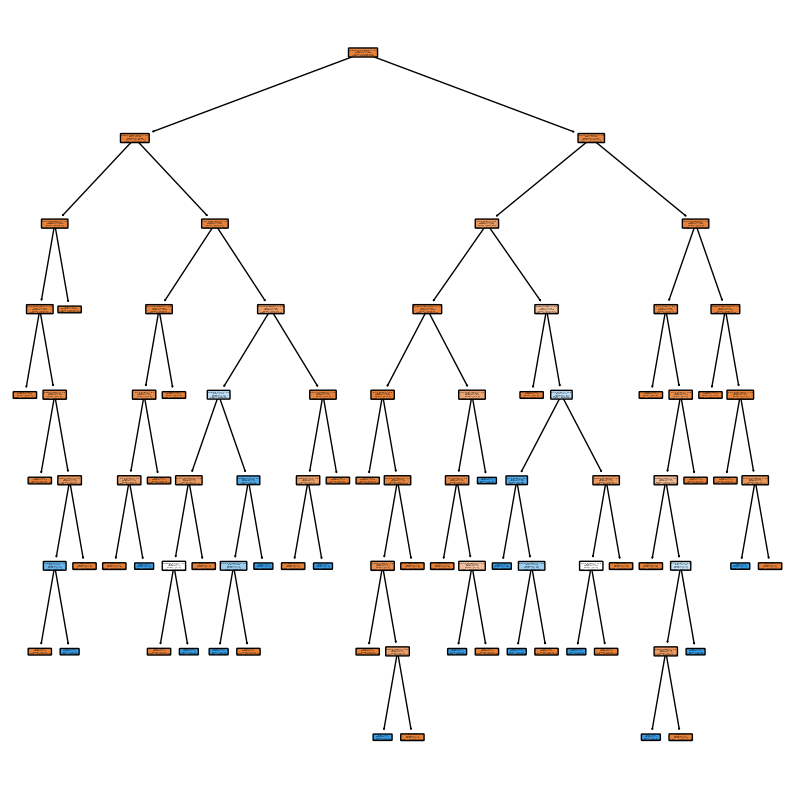

In [31]:
make_model_etc(target, features, labels, fig_name)

# Kans dat Haagsche degradeert

In [32]:
fig_name = 'degradatie.svg'

target = 'haagsche_degradeert'
labels = ['handhaving', 'degradatie']
features =  wedstrijden

target='haagsche_degradeert'


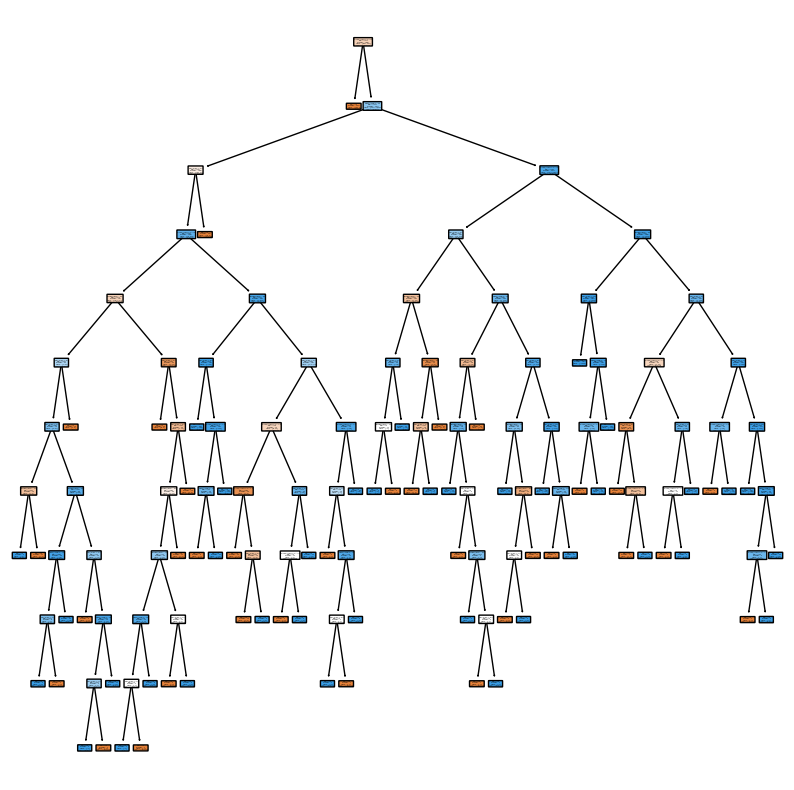

In [33]:
make_model_etc(target, features, labels, fig_name)

In [34]:
fig_name = 'degradatie_extra_features.svg'

target = 'haagsche_degradeert'
labels = ['handhaving', 'degradatie']
features = wedstrijden + [
    'eindh_broekp_gelijk',
    'broekp_haagsche_gelijk', 
    'duke_eindh_gelijk',
    'wouwse_duke_gelijk',
]

target='haagsche_degradeert'


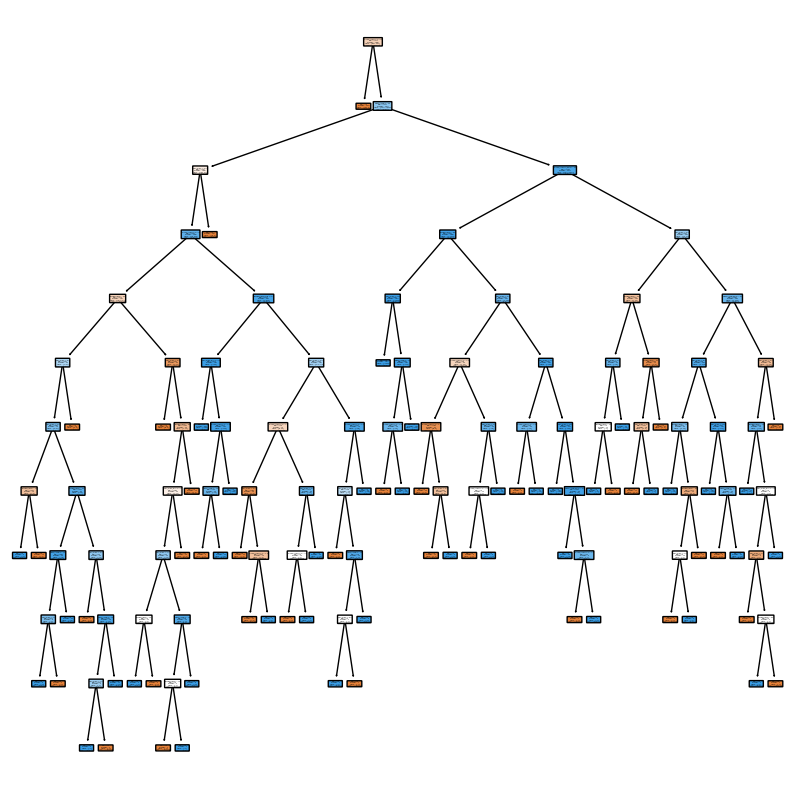

In [35]:
make_model_etc(target, features, labels, fig_name)